In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.tv_reconstruct import TVReconstruct
from bimpcc.utils_recons import apply_blur, gaussian_psf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,blur,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(blur,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,blur)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [18]:
scale = 20

In [19]:
dataset = get_dataset("cameraman",scale=scale)
true, _= dataset.get_training_data()
psf_0 = gaussian_psf(3,0.5)
blur_img = apply_blur(true, psf_0)

(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

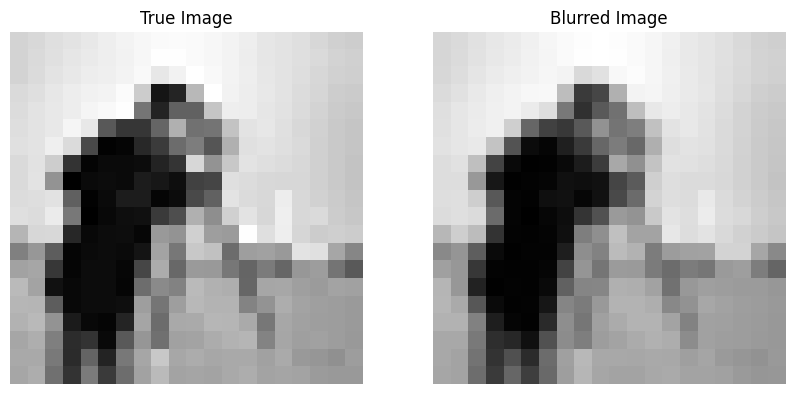

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(blur_img,cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

In [21]:
model = TVReconstruct(true, blur_img, epsilon=1e-3)

In [22]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16840
Number of nonzeros in inequality constraint Jacobian.:     1900
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2301
                     variables with only lower bounds:     1161
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1920
Total number of inequality constraints...............:      760
        inequality constraints with only lower bounds:      760
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1421975e-01 5.94e-01 1.40e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

0                 0  0.2959275424426199      4.969868853691454                  1.0

Variable bound violation:   9.9746372053937521e-09    9.9746372053937521e-09
Complementarity.........:   1.0000000040817951e-11    1.0000000040817951e-11
Overall NLP error.......:   9.1891488209255634e-09    9.1891488209255634e-09


Number of objective function evaluations             = 1339
Number of objective gradient evaluations             = 859
Number of equality constraint evaluations            = 1339
Number of inequality constraint evaluations          = 1339
Number of equality constraint Jacobian evaluations   = 859
Number of inequality constraint Jacobian evaluations = 859
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 53.942

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16840
Number of nonzeros in inequality constraint Jacobian.:     1900
Number of nonzeros in Lagrangian Hessian.............:      

1                 0  0.2846275984330904      4.173474066612149                  0.5

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    16840
Number of nonzeros in inequality constraint Jacobian.:     1900
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2301
                     variables with only lower bounds:     1161
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1920
Total number of inequality constraints...............:      760
        inequality constraints with only lower bounds:      760
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8629712e-01 2.38e-01 1.11e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

KeyboardInterrupt: 

In [16]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = model.objective_func.parse_vars(x_opt_mpcc)

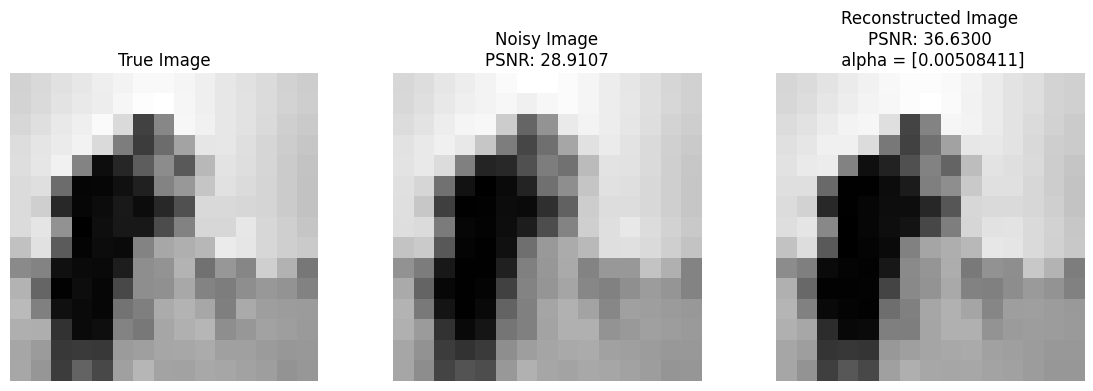

In [17]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,blur_img,u_mpcc,alpha_mpcc)